In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%reload_ext autoreload

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import os
import tqdm as notebook_tqdm
from anndata import AnnData
import scanpy.external as sce


In [4]:
from src.config import *
from src.prediction_functions import *

# Read in data

#### Model

In [5]:
lincs_model = pd.read_csv('data/coefficient_matrix/high_quality/all_pert_coef_liana.csv', index_col = 0)
lincs_model = lincs_model.T

#### scRNA-Seq data of RCC patients

In [6]:
filenames = os.listdir('data/sc_rcc/GSE159115_RAW/')

In [9]:
adata = {}
for file in filenames:
    patient_id = ('_').join(file.split('_')[1:3])
    adata[patient_id] = sc.read_10x_h5(f'data/sc_rcc/GSE159115_RAW/{file}')
    adata[patient_id].var_names_make_unique()

In [10]:
for patient_id in adata:
    adata[patient_id].obs_names =  patient_id + '_' + adata[patient_id].obs_names

### Metadata

In [11]:
metadata = pd.read_excel(f'data/sc_rcc/pnas.2103240118.sd01.xlsx', sheet_name='patient_cohort', index_col = 0)

In [12]:
metadata['filename'] = metadata['Single cell Sequencing SI_ID'].apply(lambda x: next((f for f in filenames if x in f), None))


In [13]:
# select  patient only with clear cell carcinoma
ccRCC_patients = metadata[metadata['Cancer Type'] == 'Clear Cell RCC']

#### Cell annotation

In [14]:
ccRCC_cellannotation = pd.read_csv(f'data/sc_rcc/GSE159115_ccRCC_anno.csv.gz', compression='gzip', index_col = 0)

#### Filter anndata for RCC patients

In [15]:
rcc_adata = {k: v for k, v in adata.items() if k in ccRCC_patients['Single cell Sequencing SI_ID'].unique()}


# Combine studies

In [16]:
combined_adata = sc.concat(rcc_adata, join='outer')

In [17]:
combined_adata.obs['patient_id'] = combined_adata.obs_names.str[0:8]

In [18]:
combined_adata.obs['cell_type'] = combined_adata.obs_names.map(ccRCC_cellannotation['anno'])
combined_adata.obs['cluster'] = combined_adata.obs_names.map(ccRCC_cellannotation['cluster'].astype(int))
combined_adata.obs['cluster'] = combined_adata.obs['cluster'].astype('str')

In [19]:
print("Number of genes %d"%combined_adata.n_vars)
print("Number of cells %d"%combined_adata.n_obs)


Number of genes 33694
Number of cells 21951


### Filtering data
- Potential doublets identified by scrublet were also removed from further analyses. 
- Low expressed genes (detected in less than five cells) and a list of uninformative genes were removed including mitochondrial, ribosomal, and sex genes before the total number of UMI was standardized to 5,000 per cell and log-transformed [log2(X+1)]. 
- When different samples were pooled, highly variable genes (HVGs) were identified and batch correction with fastMNN (12) was applied based on HVGs to remove batch effect before clustering.

In [20]:
sce.pp.scrublet(combined_adata, batch_key = 'patient_id')

Automatically set threshold at doublet score = 0.39
Detected doublet rate = 0.3%
Estimated detectable doublet fraction = 15.4%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 1.9%
Automatically set threshold at doublet score = 0.27
Detected doublet rate = 0.6%
Estimated detectable doublet fraction = 31.2%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 1.9%
Automatically set threshold at doublet score = 0.29
Detected doublet rate = 1.4%
Estimated detectable doublet fraction = 38.1%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 3.8%
Automatically set threshold at doublet score = 0.30
Detected doublet rate = 0.8%
Estimated detectable doublet fraction = 18.7%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 4.3%
Automatically set threshold at doublet score = 0.31
Detected doublet rate = 0.6%
Estimated detectable doublet fraction = 30.4%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 1.9%
Automatically set threshold at doublet score = 0.25
Detected doub

In [21]:
combined_adata = combined_adata[~combined_adata.obs['predicted_doublet'].astype(bool)]

In [22]:
sc.pp.filter_cells(combined_adata, min_genes=300)
sc.pp.filter_genes(combined_adata, min_cells=5)


In [23]:
print("Remaining cells %d"%combined_adata.n_obs)


Remaining cells 21571


In [24]:
combined_adata.var['mt'] = combined_adata.var_names.str.startswith('MT-') 
combined_adata.var['rb'] = combined_adata.var_names.str.startswith(('RPL', 'RPS')) 
sc.pp.calculate_qc_metrics(combined_adata, qc_vars=['mt', 'rb'], percent_top=None, log1p=False, inplace=True)

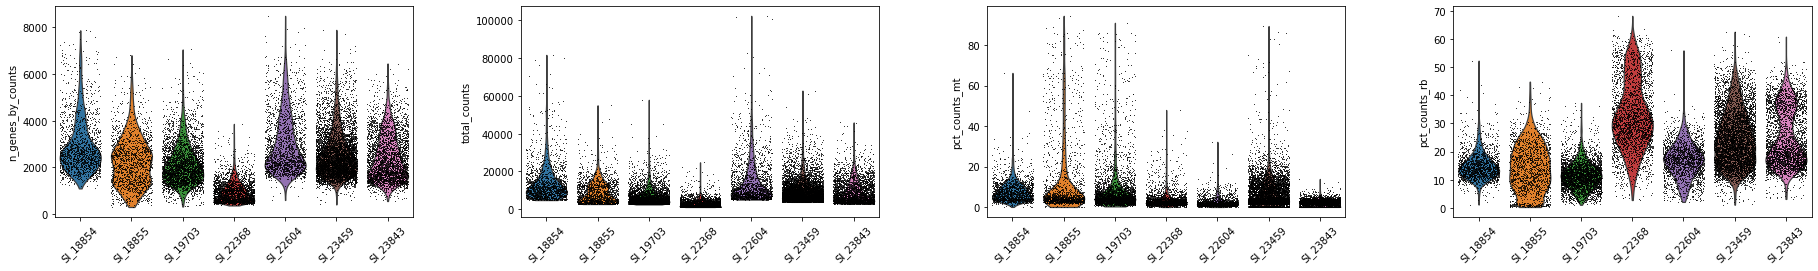

In [25]:
sc.pl.violin(combined_adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt','pct_counts_rb'],
             jitter=0.4, groupby = 'patient_id', rotation= 45)

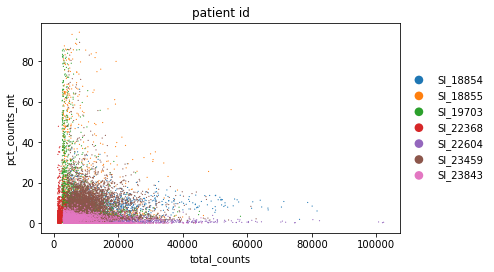

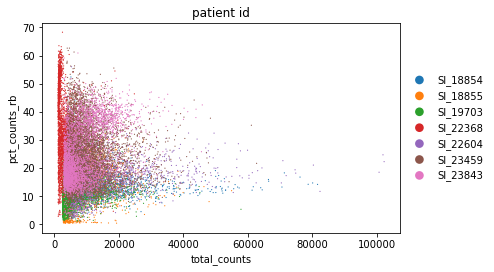

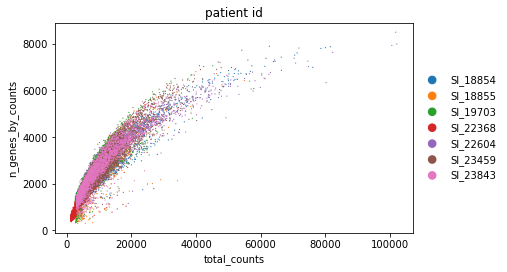

In [26]:
sc.pl.scatter(combined_adata, x='total_counts', y='pct_counts_mt', color='patient_id')
sc.pl.scatter(combined_adata, x='total_counts', y='pct_counts_rb',  color='patient_id')
sc.pl.scatter(combined_adata, x='total_counts', y='n_genes_by_counts',  color='patient_id')

#### Sex checking

In [27]:
annot = sc.queries.biomart_annotations(
        "hsapiens",
        ["ensembl_gene_id", "external_gene_name", "start_position", "end_position", "chromosome_name"],
    ).set_index("external_gene_name")

In [28]:
chrX_genes = combined_adata.var_names.intersection(annot.index[annot.chromosome_name == "X"])
chrY_genes = combined_adata.var_names.intersection(annot.index[annot.chromosome_name == "Y"])


In [29]:
len(chrX_genes), len(chrY_genes)

(608, 36)

In [30]:
combined_adata.var['chrY'] = combined_adata.var_names.isin(chrY_genes)
combined_adata.var['chrX'] = combined_adata.var_names.isin(chrX_genes)

In [31]:
fil = ~combined_adata.var['chrX'] & ~combined_adata.var['chrY'] & ~combined_adata.var['mt'] & ~combined_adata.var['rb']

In [32]:
combined_adata = combined_adata[:, fil]

In [33]:
print("Remaining genes %d"%combined_adata.n_vars)


Remaining genes 22361


In [34]:
combined_adata = combined_adata[combined_adata.obs.pct_counts_mt < 25, :]
combined_adata = combined_adata[combined_adata.obs.pct_counts_rb >5, :]

In [35]:
print("Remaining cells %d"%combined_adata.n_obs)


Remaining cells 20645


#### Normalization

In [36]:
combined_adata.raw = combined_adata


In [37]:
sc.pp.normalize_total(combined_adata, target_sum=5e3)


In [38]:
sc.pp.log1p(combined_adata)


In [39]:
combined_adata.raw = combined_adata


In [40]:
adata2 = combined_adata.copy() 


In [41]:
sc.pp.highly_variable_genes(adata2, min_mean=0.0125, max_mean=3, min_disp=0.5, batch_key = 'patient_id')

### Batch effect

In [42]:
print("Number of batches where gene is variable:")
print(adata2.var.highly_variable_nbatches.value_counts())
var_genes_batch = adata2.var.highly_variable_nbatches > 0

Number of batches where gene is variable:
0    15082
1     3553
2     1383
3      710
4      537
5      405
6      353
7      338
Name: highly_variable_nbatches, dtype: int64


In [44]:
sc.tl.pca(adata2, use_highly_variable=True, n_comps=50)
sc.pp.neighbors(adata2, n_neighbors=15, use_rep = 'X_pca')
sc.external.pp.bbknn(adata2, batch_key='patient_id', n_pcs=50) 


In [45]:
sc.external.pp.bbknn(adata2, batch_key='patient_id', n_pcs=50) 


In [46]:
sc.tl.umap(adata2)
sc.tl.tsne(adata2)

In [47]:
sc.pp.scale(adata2, max_value=10)


In [48]:
data = pd.DataFrame(adata2.X, index = adata2.obs_names, columns = adata2.var_names)

In [49]:
adata2.obsm['receptor_activity'] = estimate_receptor_activity(data, lincs_model, number_of_permutations=1000, chunk_size=300)

Number of samples: 20645
Number of chunks: 69
Number of permutations: 1000


100%|██████████| 69/69 [05:40<00:00,  4.93s/it]


In [50]:
def get_acts(adata, obsm_key, dtype=np.float32):
    """
    Extracts activities as AnnData object.

    From an AnnData object with source activities stored in ``.obsm``, generates a new AnnData object with activities in ``X``.
    This allows to reuse many scanpy processing and visualization functions.

    Parameters
    ----------
    adata : AnnData
        Annotated data matrix with activities stored in ``.obsm``.
    obsm_key : str
        ``.osbm`` key to extract.
    dtype : type
        Type of float used.

    Returns
    -------
    acts : AnnData
        New AnnData object with activities in ``X``.
    """

    obs = adata.obs
    var = pd.DataFrame(index=adata.obsm[obsm_key].columns)
    uns = adata.uns
    obsm = adata.obsm

    return AnnData(np.array(adata.obsm[obsm_key]).astype(dtype), obs=obs, var=var, uns=uns, obsm=obsm)

In [51]:
acts = get_acts(adata2, obsm_key = 'receptor_activity')

In [52]:
map_cell_type = {
    'Tumor':'Tumor', 
    'Macro':'Macro', 
    'Macro_MKI67':'Macro', 
    'Mast':'Mast', 
    'Tcell':'Tcell', 
    'Tcell_CD8':'Tcell', 
    'ua':'unkown',
    np.nan:'unkown', 
    'Peri':'Pericytes', 
    'Plasma':'Plasma', 
    'Endo_PLVAP':'Endothelial', 
    'Endo_ACKR1':'Endothelial', 
    'Bcell':'Bcell', 
    'vSMC':'vSMC'
}

In [53]:
acts.obs['cell_type_less'] = acts.obs['cell_type'].map(map_cell_type)

In [54]:
acts2 = acts[acts.obs.cell_type.notna()]
acts2.obs['cell_type_less'] = acts2.obs['cell_type'].map(map_cell_type)

In [55]:
adata2 = adata2[adata2.obs.cell_type.notna()]
adata2.obs['cell_type_less'] = adata2.obs['cell_type'].map(map_cell_type)

In [56]:
# sc.write("results/validation/anti_pd1/single_cell/receptor_activities_rcc.h5ad", acts2)
# sc.write("results/validation/anti_pd1/single_cell/gene_expression_rcc.h5ad", adata2)


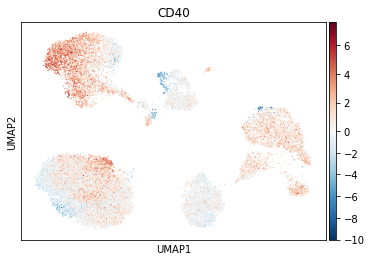

In [57]:
sc.pl.umap(acts, color=['CD40'], cmap='RdBu_r', vcenter=0)

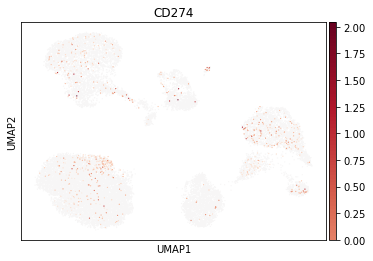

In [58]:

sc.pl.umap(adata2, color=['CD274'], cmap='RdBu_r', vcenter=0) #, save='umap_cd274_gex.png'

In [59]:
data = pd.DataFrame(acts2.X, index = acts2.obs_names, columns = acts2.var_names)
hue = acts2.obs['cell_type_less']

In [60]:
df = pd.merge(data, hue, left_index = True, right_index = True)

In [61]:
median_values = df.groupby('cell_type_less')['PDCD1'].median().sort_values()
order = median_values.index

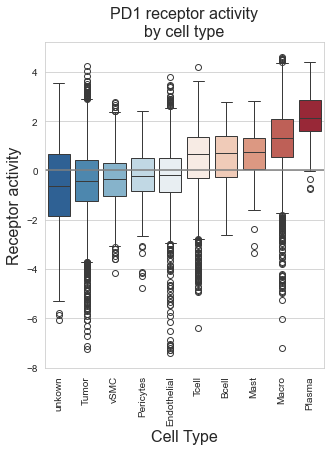

In [62]:
sns.set_style("whitegrid")
plt.figure(figsize=(5, 6))
sns.boxplot(x='cell_type_less', y='PDCD1', data=df, palette= 'RdBu_r', order = list(order))
plt.title('PD1 receptor activity\nby cell type', fontsize = 16)
plt.xticks(rotation = 90, fontsize = 10)
plt.yticks(fontsize = 10)
plt.xlabel('Cell Type', fontsize = 16)
plt.ylabel('Receptor activity', fontsize = 16)
plt.axhline(0, color = 'gray')
# plt.savefig('figures/boxplot_receptor_activity_lesscell.pdf' ,bbox_inches = 'tight', transparent = True)
plt.show()